In [18]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.ToTensor()
train_data = datasets.CIFAR10(root='./data', train=True, transform = transform, download = True)
train_loader = DataLoader(train_data, batch_size=128, shuffle = True)

Files already downloaded and verified


In [19]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(images.shape)

torch.Size([128, 3, 32, 32])


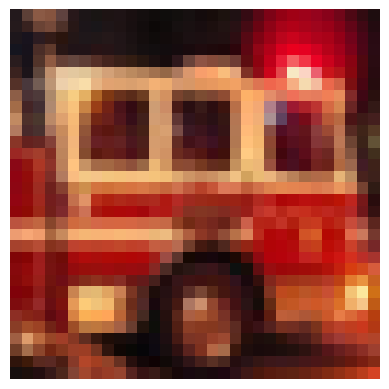

In [20]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img.numpy()
    img = np.transpose(img, (1,2,0))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
imshow(images[2])

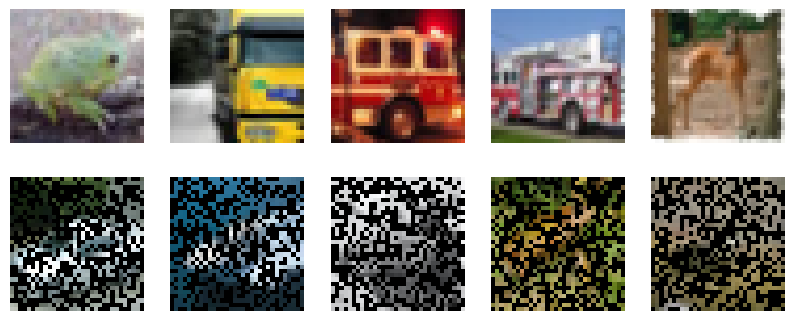

In [21]:
def show_original_and_masked(original, masked, n=5):
    fig, axs = plt.subplots(2, n, figsize=(n*2,4))
    for i in range(n):
        orig = np.transpose(original[i].numpy(), (1,2,0))
        maskd = np.transpose(masked[i].numpy(), (1,2,0))
        axs[0,i].imshow(orig)
        axs[0,i].axis('off')
        axs[1,i].imshow(maskd)
        axs[1,i].axis('off')
    axs[0,0].set_ylabel("Orijinal")
    axs[1,0].set_ylabel("Maskeli")
    plt.show()
show_original_and_masked(images, masked_images)

In [22]:
import torchvision.models as models
resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

In [23]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import resnet18, ResNet18_Weights

class ResNetAutoEncoder(nn.Module):
    def __init__(self):
        super(ResNetAutoEncoder, self).__init__()

        resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        self.encoder = nn.Sequential(*list(resnet.children())[:3])

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64,32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32,16, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(16, 3, kernel_size=3, padding=1),
            nn.Upsample(size=(32,32), mode='bilinear'))
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [24]:
model = ResNetAutoEncoder()

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [26]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [29]:
num_epochs = 30
loss_values = []

for epoch in range(num_epochs):
    model.train()
    running_loss= 0.0

    for images, _ in train_loader:
        mask = (torch.rand(images.shape[0], 1, 32, 32) > 0.5).float()
        mask = mask.repeat(1, 3, 1, 1)
        mask = mask.to(images.device)
        masked_images = images * mask 

        images = images.to(device)
        masked_images = masked_images.to(device)

        outputs = model(masked_images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    loss_values.append(epoch_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

Epoch [1/30], Loss: 0.0119
Epoch [2/30], Loss: 0.0104
Epoch [3/30], Loss: 0.0094
Epoch [4/30], Loss: 0.0090
Epoch [5/30], Loss: 0.0087
Epoch [6/30], Loss: 0.0085
Epoch [7/30], Loss: 0.0082
Epoch [8/30], Loss: 0.0076
Epoch [9/30], Loss: 0.0074
Epoch [10/30], Loss: 0.0071
Epoch [11/30], Loss: 0.0070
Epoch [12/30], Loss: 0.0068
Epoch [13/30], Loss: 0.0066
Epoch [14/30], Loss: 0.0064
Epoch [15/30], Loss: 0.0063
Epoch [16/30], Loss: 0.0063
Epoch [17/30], Loss: 0.0062
Epoch [18/30], Loss: 0.0062
Epoch [19/30], Loss: 0.0061
Epoch [20/30], Loss: 0.0061
Epoch [21/30], Loss: 0.0060
Epoch [22/30], Loss: 0.0060
Epoch [23/30], Loss: 0.0059
Epoch [24/30], Loss: 0.0058
Epoch [25/30], Loss: 0.0058
Epoch [26/30], Loss: 0.0057
Epoch [27/30], Loss: 0.0058
Epoch [28/30], Loss: 0.0058
Epoch [29/30], Loss: 0.0057
Epoch [30/30], Loss: 0.0058


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0051935557..1.0748703].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.07837615..1.0524184].


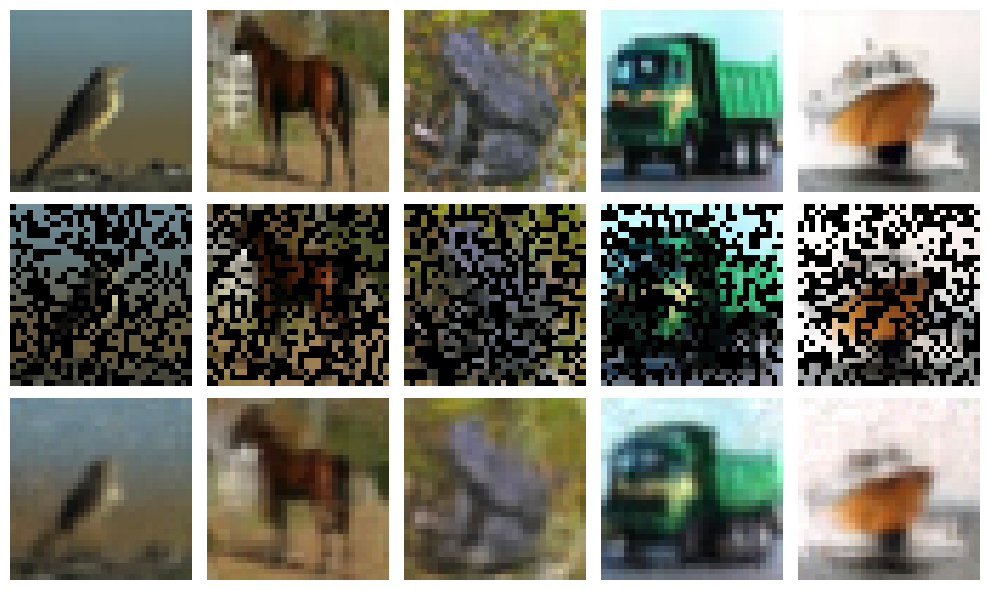

In [30]:
import matplotlib.pyplot as plt
import numpy as np

model.eval()

with torch.no_grad():
    outputs = model(masked_images)

images = images.cpu()
masked_images = masked_images.cpu()
outputs = outputs.cpu()

def show_images(original, masked, reconstructed, n=5):
    fig, axs = plt.subplots(3, n, figsize=(n*2, 6))
    for i in range(n):
        axs[0, i].imshow(np.transpose(original[i].numpy(), (1, 2, 0)))
        axs[0, i].axis('off')
        axs[1, i].imshow(np.transpose(masked[i].numpy(), (1, 2, 0)))
        axs[1, i].axis('off')
        axs[2, i].imshow(np.transpose(reconstructed[i].numpy(), (1, 2, 0)))
        axs[2, i].axis('off')
    axs[0, 0].set_ylabel("Orijinal")
    axs[1, 0].set_ylabel("Maskeli")
    axs[2, 0].set_ylabel("Tahmin")
    plt.tight_layout()
    plt.show()

show_images(images, masked_images, outputs)

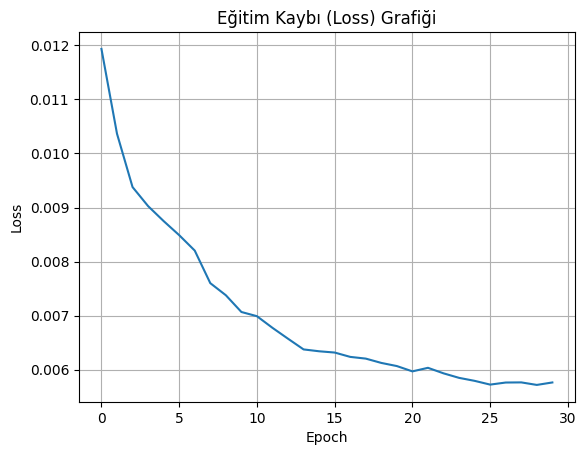

In [31]:
import matplotlib.pyplot as plt

plt.plot(loss_values)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Eğitim Kaybı (Loss) Grafiği")
plt.grid(True)
plt.show()

In [32]:
import torch.nn.functional as F
import math

mse = F.mse_loss(outputs, images).item()
psnr = 10 * math.log10(1 / mse)

print(f"MSE: {mse:.6f}")
print(f"PSNR: {psnr:.2f} dB")

MSE: 0.005661
PSNR: 22.47 dB


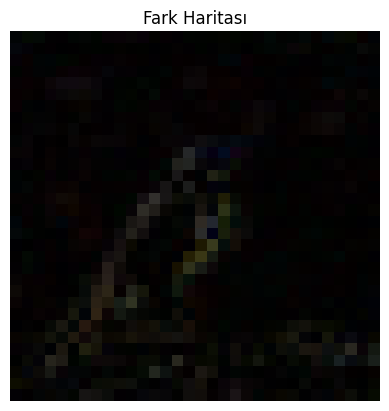

In [33]:
diff = torch.abs(outputs[0] - images[0])
plt.imshow(diff.permute(1,2,0))
plt.title("Fark Haritası")
plt.axis('off')
plt.show()

In [34]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Toplam Öğrenilebilir Parametre: {count_parameters(model):,}")

Toplam Öğrenilebilir Parametre: 116,579
